# Step 2A: Color Space Conversions(Jupyter Notebook)

In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt
import io

In [11]:
# Load your selfie
selfie = cv2.imread('my_selfie.jpg')


**Notation.** OpenCV images are **BGR** (8-bit) with channels in $[0,255]$.
Let $B,G,R\in[0,255]$ and normalized $b=B/255,\ g=G/255,\ r=R/255$.

For all worked examples below, use the same test pixel:

* **Test pixel (BGR):** $B=64,\ G=128,\ R=192$
* **Normalized:** $b=0.25098,\ g=0.50196,\ r=0.75294$ (i.e., value/255)

In [18]:
# Conversions
rgb = cv2.cvtColor(selfie, cv2.COLOR_BGR2RGB)
gray  = cv2.cvtColor(selfie, cv2.COLOR_BGR2GRAY)
hsv   = cv2.cvtColor(selfie, cv2.COLOR_BGR2HSV)
lab   = cv2.cvtColor(selfie, cv2.COLOR_BGR2LAB)
ycrcb = cv2.cvtColor(selfie, cv2.COLOR_BGR2YCrCb)

1. Original BGR Image


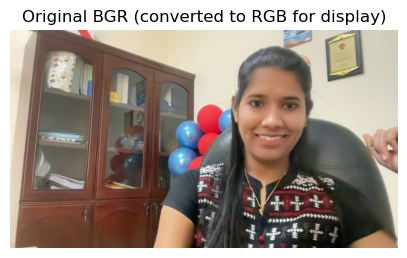

✅ Displayed: Original BGR image



In [19]:
# 1. Original BGR
print("1. Original BGR Image")
plt.figure(figsize=(5, 4))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Original BGR (converted to RGB for display)')
plt.show()
print("✅ Displayed: Original BGR image")
print()

### 2) BGR → Grayscale (BT.601 luma)

$$
Y' = 0.114\,B + 0.587\,G + 0.299\,R \quad (0\ldots255)
$$

Equivalently (normalized): $y' = 0.114\,b + 0.587\,g + 0.299\,r$, then **Gray** $= 255\,y'$.

**Worked example.**
$Y' = 0.114\cdot64 + 0.587\cdot128 + 0.299\cdot192 = 139.84 \Rightarrow \textbf{Gray} \approx 140$.

2. Grayscale Conversion


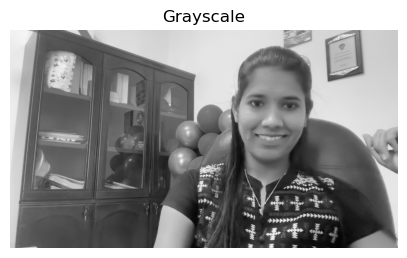

✅ Displayed and saved: Grayscale conversion



In [20]:
# 2. Convert to Grayscale
print("2. Grayscale Conversion")
plt.figure(figsize=(5, 4))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale')
plt.show()
print("✅ Displayed and saved: Grayscale conversion")
print()

### 3) BGR → HSV (OpenCV scaling)

Let

$$
C_{\max}=\max(r,g,b),\quad C_{\min}=\min(r,g,b),\quad \Delta=C_{\max}-C_{\min}.
$$

**Hue** $H$ (degrees):

$$
H=
\begin{cases}
0, & \Delta=0\\[4pt]
60\left(\dfrac{g-b}{\Delta}\bmod 6\right), & C_{\max}=r\\[8pt]
60\left(\dfrac{b-r}{\Delta}+2\right), & C_{\max}=g\\[8pt]
60\left(\dfrac{r-g}{\Delta}+4\right), & C_{\max}=b
\end{cases}
$$

**Saturation** $S$:

$$
S=
\begin{cases}
0, & C_{\max}=0\\[4pt]
\dfrac{\Delta}{C_{\max}}, & \text{otherwise}
\end{cases}
\qquad \text{Value } V=C_{\max}.
$$

**OpenCV 8-bit storage:**

$$
H_{\text{cv}}=\left\lfloor \tfrac{H}{2} \right\rfloor\in[0,179],\quad
S_{\text{cv}}=\lfloor 255\,S\rfloor,\quad
V_{\text{cv}}=\lfloor 255\,V\rfloor.
$$

**Worked example.**
$C_{\max}=0.75294,\ C_{\min}=0.25098,\ \Delta=0.50196$. Since $C_{\max}=r$:

* $H=60\cdot\frac{g-b}{\Delta}=60\cdot0.5=30^\circ \Rightarrow H_{\text{cv}}=\lfloor 30/2\rfloor=15$
* $S=\Delta/C_{\max}}=0.50196/0.75294=\tfrac{2}{3} \Rightarrow S_{\text{cv}}=\lfloor 255\cdot\tfrac{2}{3}\rfloor=170$
* $V=C_{\max}=0.75294 \Rightarrow V_{\text{cv}}=\lfloor 255\cdot0.75294\rfloor=192$

**HSV (OpenCV 8-bit):** $(15,\ 170,\ 192)$.


3. HSV Color Space


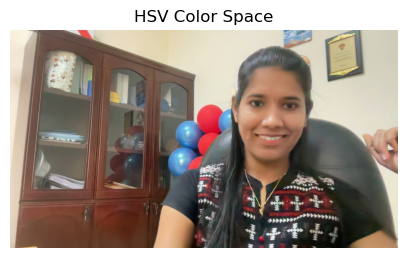

✅ Displayed and saved: HSV color space



In [21]:
# 3. Convert to HSV
print("3. HSV Color Space")
plt.figure(figsize=(5, 4))
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
plt.axis('off')
plt.title('HSV Color Space')
plt.show()
cv2.imwrite('hsv_selfie.jpg', hsv)
print("✅ Displayed and saved: HSV color space")
print()


### 4) BGR → CIE L\*a\*b\* (D65/2°)

**(a) Linearize sRGB** (gamma→linear):

$$
 c_\ell =
 \begin{cases}
 \dfrac{c}{12.92}, & c\le 0.04045 \\
 \left(\dfrac{c+0.055}{1.055}\right)^{2.4}, & c>0.04045
 \end{cases}
 \quad (c\in\{r,g,b\})
$$

**(b) Linear RGB → XYZ (D65):**

$$
\begin{bmatrix} X\\ Y\\ Z \end{bmatrix}=
\begin{bmatrix}
0.4124564 & 0.3575761 & 0.1804375\\
0.2126729 & 0.7151522 & 0.0721750\\
0.0193339 & 0.1191920 & 0.9503041
\end{bmatrix}
\begin{bmatrix} r_\ell\\ g_\ell\\ b_\ell \end{bmatrix}
$$

**(c) XYZ → L\*a\*b\*** (D65 white $(X_n,Y_n,Z_n)=(95.047,100.000,108.883)$):

$$
 f(t)=\begin{cases}
 t^{1/3}, & t>\varepsilon \\
 \dfrac{\kappa t+16}{116}, & \text{otherwise}
 \end{cases}
\quad \varepsilon=\tfrac{216}{24389},\ \kappa=\tfrac{24389}{27}.
$$

$$
\begin{aligned}
L^*&=116\,f\!\left(\tfrac{Y}{Y_n}\right)-16,\\
 a^*&=500\!\left[f\!\left(\tfrac{X}{X_n}\right)-f\!\left(\tfrac{Y}{Y_n}\right)\right],\\
 b^*&=200\!\left[f\!\left(\tfrac{Y}{Y_n}\right)-f\!\left(\tfrac{Z}{Z_n}\right)\right].
\end{aligned}
$$

**OpenCV 8-bit encoding:** $L^*\in[0,100]\Rightarrow L_{\text{cv}}\approx 255\,L^*/100$; $a^*,b^*\in[-128,127]\Rightarrow +128$ shift to $[0,255]$.

**Worked example (approx).**
Linearized sRGB: $r_\ell\approx 0.5271,\ g_\ell\approx 0.2159,\ b_\ell\approx 0.05127$
XYZ: $(X,Y,Z)\approx (0.30385,\,0.27018,\,0.08464)$
Lab: $(L^*,a^*,b^*)\approx (58.99,\,18.65,\,43.94)$
OpenCV 8-bit: $L_{\text{cv}}\approx 150,\ a_{\text{cv}}\approx 147,\ b_{\text{cv}}\approx 172$

**Lab (OpenCV 8-bit):** $(150,\ 147,\ 172)$.

4. LAB Color Space


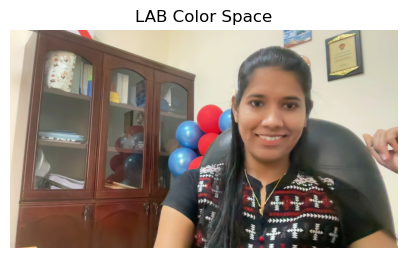

✅ Displayed and saved: LAB color space



In [22]:
# 4. Convert to LAB
print("4. LAB Color Space")
plt.figure(figsize=(5, 4))
plt.imshow(cv2.cvtColor(lab, cv2.COLOR_LAB2RGB))
plt.axis('off')
plt.title('LAB Color Space')
plt.show()
cv2.imwrite('lab_selfie.jpg', lab)
print("✅ Displayed and saved: LAB color space")
print()

### 5) BGR → YCrCb (JPEG/BT.601, full-range)

Luma (gamma-encoded channels):

$$
Y' = 0.114\,B + 0.587\,G + 0.299\,R.
$$

Chromas (8-bit full-range with 128 offset):

$$
\begin{aligned}
\mathrm{Cb} &= 128 + 0.564\,(B - Y')\\
\mathrm{Cr} &= 128 + 0.713\,(R - Y')
\end{aligned}
$$

> In OpenCV arrays the order is **Y–Cr–Cb** for `COLOR_BGR2YCrCb`.

**Worked example.**
$Y'=139.84 \Rightarrow \approx 140$
$\mathrm{Cb}=128+0.564(64-139.84)=85.23\approx 85$
$\mathrm{Cr}=128+0.713(192-139.84)=165.19\approx 165$

**YCrCb (OpenCV order Y–Cr–Cb):** $(140,\ 165,\ 85)$.

5. YCrCb Color Space


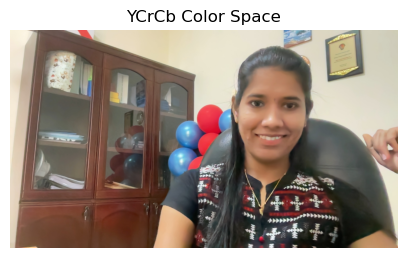

✅ Displayed and saved: YCrCb color space



In [23]:
# 5. Convert to YCrCb
print("5. YCrCb Color Space")
plt.figure(figsize=(5, 4))
plt.imshow(cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB))
plt.axis('off')
plt.title('YCrCb Color Space')
plt.show()
cv2.imwrite('ycrcb_selfie.jpg', ycrcb)
print("✅ Displayed and saved: YCrCb color space")
print()

# Step 2B: Color Space Comparison

📊 Creating Color Space Comparison Subplot...


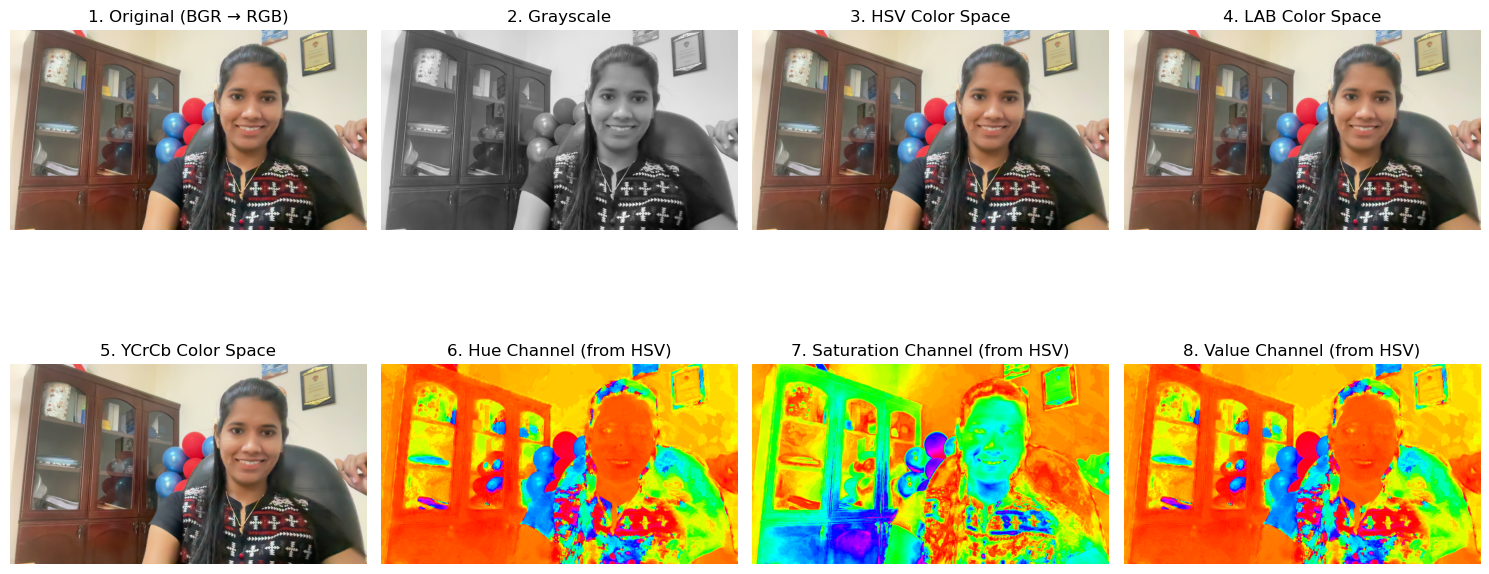

✅ Saved color space comparison: color_spaces_comparison.jpg


In [25]:
# Step 3B: Color Space Comparison Subplot
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("📊 Creating Color Space Comparison Subplot...")
print("=" * 50)

selfie = cv2.imread('my_selfie.jpg')

# Convert to different color spaces
gray = cv2.cvtColor(selfie, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(selfie, cv2.COLOR_BGR2HSV)
lab = cv2.cvtColor(selfie, cv2.COLOR_BGR2LAB)
ycrcb = cv2.cvtColor(selfie, cv2.COLOR_BGR2YCrCb)

# Create comparison subplot
plt.figure(figsize=(15, 8))

# Original BGR
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(selfie, cv2.COLOR_BGR2RGB))
plt.title('1. Original (BGR → RGB)')
plt.axis('off')

# Grayscale
plt.subplot(2, 4, 2)
plt.imshow(gray, cmap='gray')
plt.title('2. Grayscale')
plt.axis('off')

# HSV
plt.subplot(2, 4, 3)
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
plt.title('3. HSV Color Space')
plt.axis('off')

# LAB
plt.subplot(2, 4, 4)
plt.imshow(cv2.cvtColor(lab, cv2.COLOR_LAB2RGB))
plt.title('4. LAB Color Space')
plt.axis('off')

# YCrCb
plt.subplot(2, 4, 5)
plt.imshow(cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB))
plt.title('5. YCrCb Color Space')
plt.axis('off')

# Individual HSV Channels (Hue)
h, s, v = cv2.split(hsv)
plt.subplot(2, 4, 6)
plt.imshow(h, cmap='hsv')
plt.title('6. Hue Channel (from HSV)')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(s, cmap='hsv')
plt.title('7. Saturation Channel (from HSV)')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(h, cmap='hsv')
plt.title('8. Value Channel (from HSV)')
plt.axis('off')

plt.tight_layout()
plt.savefig('color_spaces_comparison.jpg', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved color space comparison: color_spaces_comparison.jpg")